In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import glob
import os
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import random
import soundfile as sf

In [2]:
df = pd.read_csv('../../Grabaciones curadas/data_catalog.csv')
df = df.query("rana_label == 'BOAFAB' and quality_label == 'C'")

In [3]:
## Auxiliar functions
def load_audio(obs, verbose=False):
    wav_path = obs.file_wav
    audio, sr = librosa.load(f'../../Grabaciones curadas/Grabaciones curadas/{wav_path}', sr=16_000)
    if verbose:
        print(obs)

    return audio, sr

def truncate_audio(audio, slice_1, slice_2):
    new_audio = audio[slice_1:slice_2]

    return new_audio

def make_plot(audio_array, sample_rate):
    plt.figure().set_figwidth(14)
    librosa.display.waveshow(audio_array, sr=sample_rate)

    ## Espectograma
    D = librosa.stft(audio_array)
    # Convert the complex-valued result to magnitude
    S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    # Display the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(S_db, x_axis="time", y_axis="hz")
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma de Frecuencia Real')
    plt.show()

def get_completation(audio, init_sec, end_sec, sr, samples=1):
    slice_1 = int(init_sec * sr); slice_2 = int(end_sec * sr)

    n_to_sec = sr - (slice_2 - slice_1)
    index_to_roll = list(range(n_to_sec)) 
    random.shuffle(index_to_roll)
    
    res = {}
    for i in range(samples):
        try:
            left_index = index_to_roll.pop()
        except:
            break
        try:
            slice_1_temp = slice_1 - left_index
            right_index = n_to_sec - left_index
            slice_2_temp = slice_2 + right_index
            sample_audio = truncate_audio(audio, slice_1_temp, slice_2_temp)
            res[i] = sample_audio
        except:
            continue

    return res


def save_audios(dict_audios, sr, audio_path, mark):
    for key in dict_audios:
        audio = dict_audios[key]
        
        new_path = f'{mark}_{key}_{audio_path}'
        sf.write(f'../data/train_gen/BOAFAB/{new_path}', audio, sr)

## Audios menores a un segundo $lenght <= 1 \ sec$ 

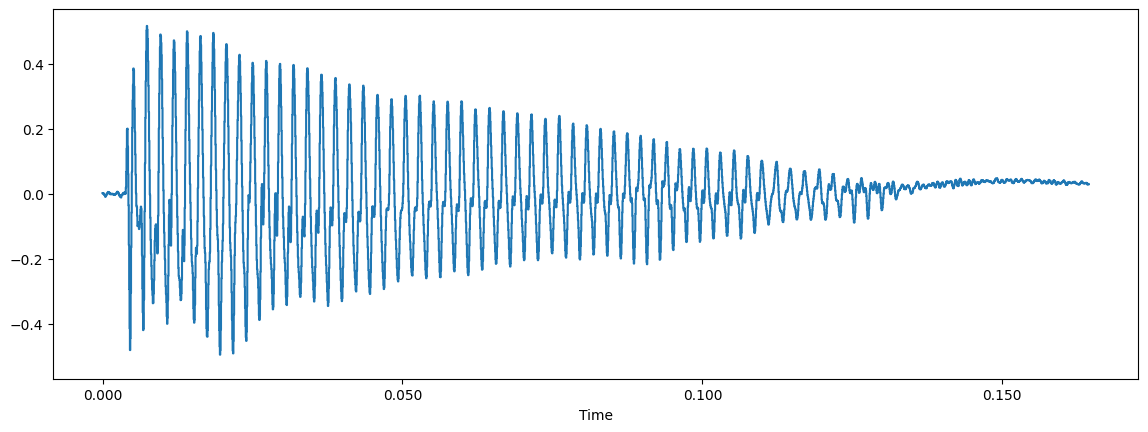

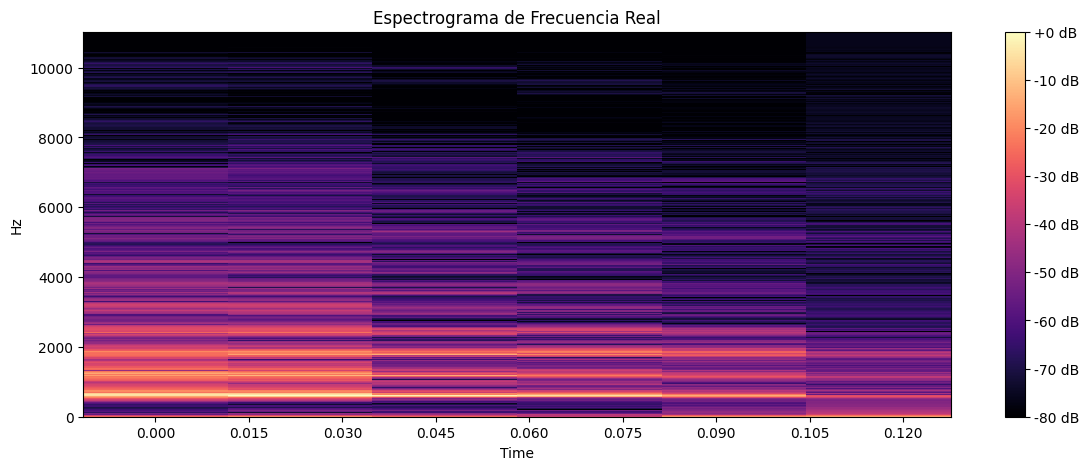

In [4]:
df_leq_one_sec = df.loc[df.length <= 1]
obs = df_leq_one_sec.iloc[40]
audio, sr = load_audio(obs)
slice_1 = int(obs.init * sr); slice_2 = int(obs.end * sr)

new_audio = truncate_audio(audio, slice_1, slice_2)
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)                

In [5]:
# res = get_completation(audio, obs.init, obs.end, sr, 100)
new_audio = res[50]
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)

NameError: name 'res' is not defined

### Ahora sí (salieron 11.700)

In [8]:
for i, obs in tqdm(df_leq_one_sec.iterrows()):
    audio, sr = load_audio(obs)
    res = get_completation(audio, obs.init, obs.end, sr, 100)
    save_audios(res, sr, obs.file_wav, i)

117it [04:57,  2.55s/it]


## Audios mayores a un segundo $lenght >= 1 \ sec$ 

In [21]:
def get_all_secs(audio, init, end, sr):
    # rolling overlaping window
    slice_1 = int(init * sr); slice_2 = int(end * sr)

    center = slice_1
    i = 0
    res = {}
    while center <= slice_2:
        slice_1_temp = int(center - (sr // 2))
        slice_2_temp = int(center + (sr // 2))

        sample_audio = truncate_audio(audio, slice_1_temp, slice_2_temp)
        res[i] = sample_audio

        center = slice_2_temp
        i += 1

    return res

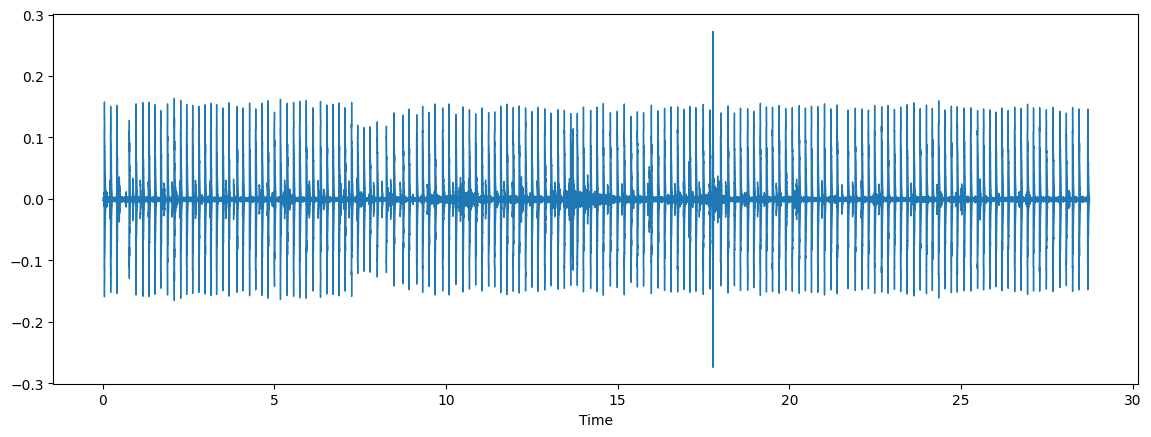

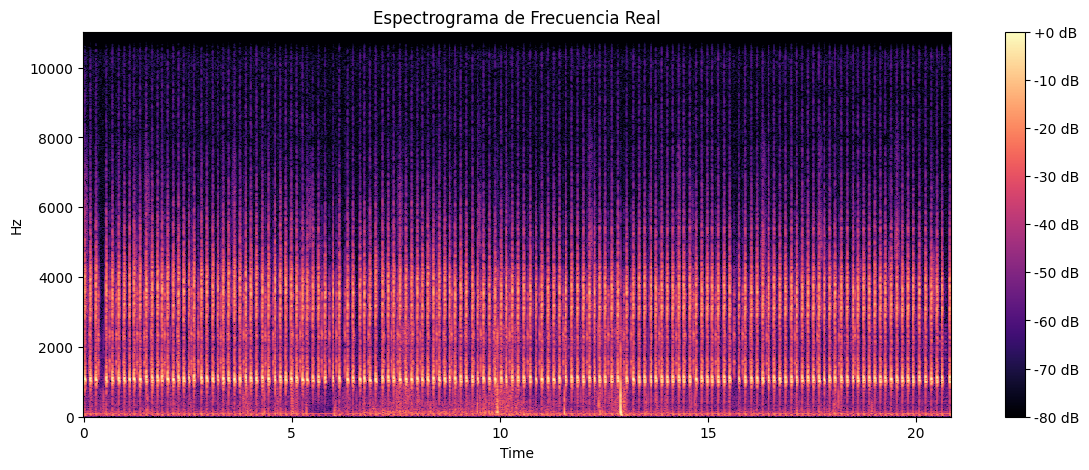

In [40]:
df_geq_one_sec = df.loc[df.length > 1]
obs = df_geq_one_sec.iloc[-1]
audio, sr = load_audio(obs)
slice_1 = int(obs.init * sr); slice_2 = int(obs.end * sr)

new_audio = truncate_audio(audio, slice_1, slice_2)
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)         

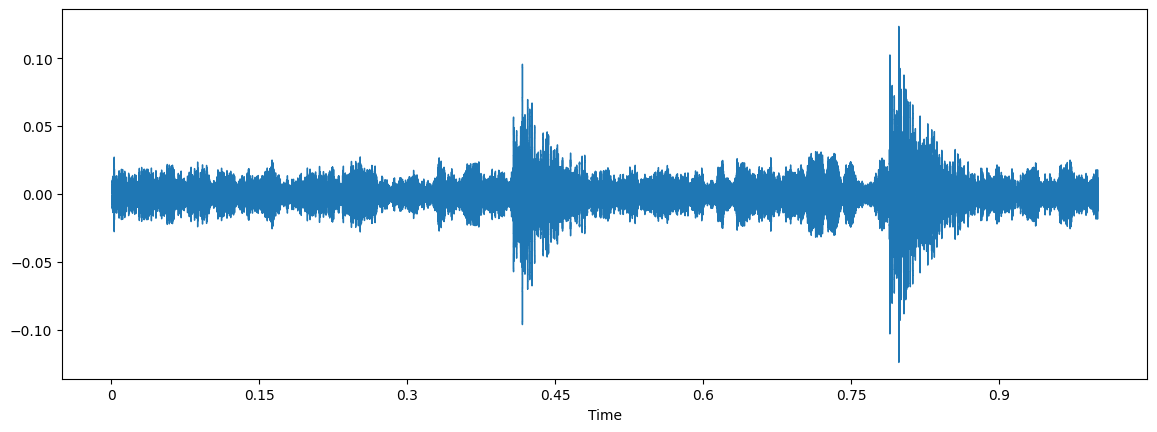

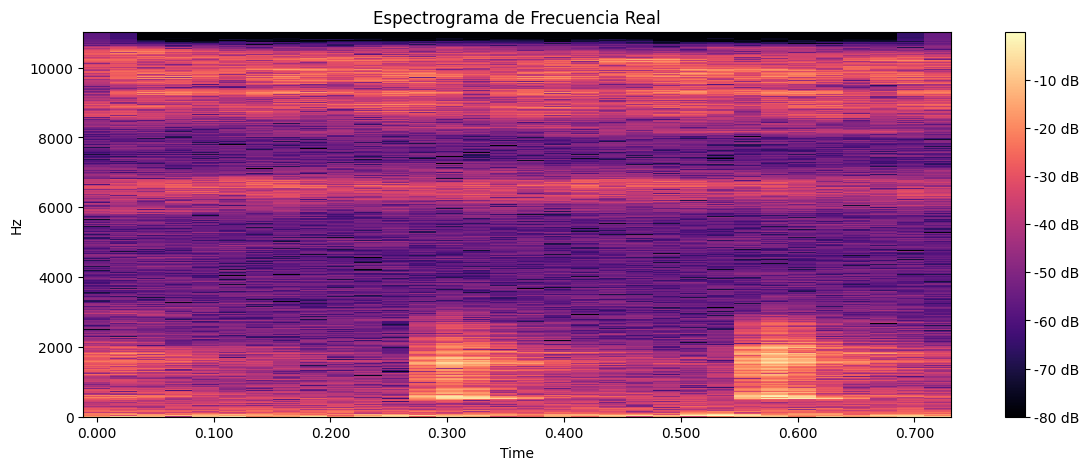

In [30]:
# res = get_all_secs(audio, obs.init, obs.end, sr)
new_audio = res[6]
make_plot(new_audio, sr)
Audio(data=new_audio, rate=sr)

### Ahora sí (salieron 2.960)

In [37]:
for i, obs in tqdm(df_geq_one_sec.iterrows()):
    audio, sr = load_audio(obs)
    res = get_all_secs(audio, obs.init, obs.end, sr)
    save_audios(res, sr, obs.file_wav, i)

54it [01:04,  1.20s/it]


In [42]:
553 / 13

42.53846153846154